In [1]:
using Gen
using Distributions
using PyPlot
using Random
using Flux
using LinearAlgebra
include("helper_functions.jl");

In [22]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 20 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 0.02 #Mode variance (classifier)

#Network hyperparameters
α = 6 #Gamma Scale for Hyperparameters

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [2]
k_real = 2

#NUTS Max Gradient
Δmax = 1000;

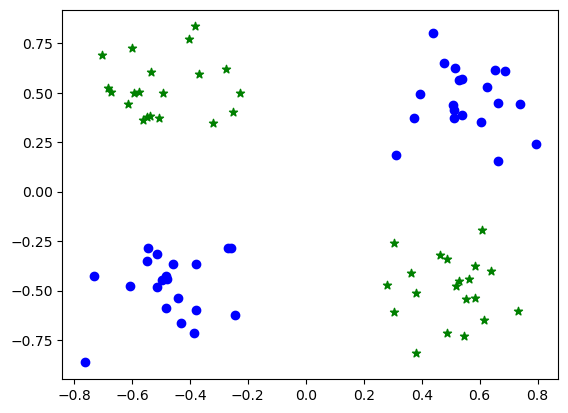

In [3]:
#Data
x_raw, classes = real_data_classifier(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data_classifier(x_raw,classes)
x = transpose(x_raw)
size(x);

In [4]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = 1
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l = 1
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    k[1] = @trace(categorical([0.0,1.0]), (:k,1))
    obs[(:k,1)] = k[1]
    #for i=1:l
        #k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        #obs[(:k,i)] = k[i]
    #end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    α = 0.001 #Gamma Scale for Hyperparameters
    
    ω₁ = 100
    ω₂ = (sum([obs[(:k,i)] for i=1:l]))*100 #Neal (1996): Scaling relationship to # of hidden units
    τ₁ ~ gamma(ω₁,α) #Hidden Weights
    τ₂ ~ gamma(ω₁,α) #Hidden Biases
    τ₃ ~ gamma(ω₂,α) #Output Weights
    
    #Standard Deviations
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σ₃ = 1/τ₃
    #σᵧ = sqrt(1/τᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = ones(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = ones(1)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = zeros(length(scores))
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

#(best_trace,) = generate(classifier, (x,), obs)
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
#println(best_trace[:τ₃])

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

29

In [29]:
traces = []
function select_hyperparameters(trace, obs)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace,weight,retdiff) = regenerate(trace, args, argdiffs, select(:τ₁,:τ₂,:τ₃))
    obs[:τ₁] = new_trace[:τ₁]
    obs[:τ₂] = new_trace[:τ₂]
    obs[:τ₃] = new_trace[:τ₃]
    return new_trace, obs
end

function select_selection_NUTS(trace)
    l = 1
    selection = select()
    for i=1:l+1
        push!(selection, (:W,i))
        push!(selection, (:b,i))
    end
    return selection
end

function run_NUTS(trace, iters, obs)
    for i=1:iters
        

        #(new_trace, hmc_score) = NUTS(trace, selection, check=false, observations=obs, M=1)
        #if rand(Uniform(0,1)) < exp(hmc_score)
            #trace = new_trace
            #accepted = true
        #else
            #accepted = false
        #end
        #push!(traces, trace)
        #accepted && println("Within accepted")
    end
    return trace
end

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(trace,) = generate(classifier, (x,), obs)

#run_NUTS(trace, 1, obs);

In [121]:
function sample_momenta(n::Int)
    Float64[random(normal, 0, 1) for _=1:n]
end

function assess_momenta(momenta)
    logprob = 0.
    for val in momenta
        logprob += Gen.logpdf(normal, val, 0, 1)
    end
    logprob
end

function NUTS(trace, ϵ, check=false, observations = obs, M=1::Int)
    #Get θ₀
    Θ = []
    args = get_args(trace)
    retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
    argdiffs = map((_) -> NoChange(), args)
    selection = select_selection_NUTS(trace)
    (_, values_trie, gradient_trie) = choice_gradients(trace, selection, retval_grad)
    θ₀ = to_array(values_trie, Float64)
    push!(Θ, θ₀)
    C_choice = 0
    
    prev_model_score = get_score(trace)
    r₀ = sample_momenta(length(θ₀))
    prev_momenta_score = assess_momenta(r₀)
        
    #Loop M times
    for m=1:M
        #Resample Position Variables
        r = r₀
        θ = from_array(values_trie, θ₀)
        (new_trace, _, _) = update(trace, args, argdiffs, θ)
        score = exp(get_score(new_trace) - 0.5(dot(r,r)))
        u = rand(Uniform(0,score))
        
        #Initialize
        θ⁻ = Θ[m]
        θ⁺ = Θ[m]
        r⁻ = r₀
        r⁺ = r₀
        j = 0
        C = Set(tuple([Θ[m], r₀]))
        s = 1
        
        while s == 1
            vⱼ = rand([-1,1])
            if vⱼ == -1
                θ⁻,r⁻,_,_,C¹,s¹ = build_tree(trace,selection,θ⁻,r⁻,u,vⱼ,j,ϵ)
            else
                _,_,θ⁺,r⁺,C¹,s¹ = build_tree(trace,selection,θ⁺,r⁺,u,vⱼ,j,ϵ)
            end
            if s¹ == 1
                C = union(C,C¹)
            end
            i¹ = (dot((θ⁺ - θ⁻),r⁻) ≥ 0) ? 1 : 0
            i² = (dot((θ⁺ - θ⁻),r⁺) ≥ 0) ? 1 : 0
            s = s¹*i¹*i²
            j += 1
        end
        C_choice = rand(unique(C))
    end
    θ = from_array(values_trie, C_choice[1])
    print
    momenta = C_choice[2]
    (new_trace, _, _) = update(trace, args, argdiffs, θ)
    
    # assess new model score (negative potential energy)
    new_model_score = get_score(new_trace)

    # assess new momenta score (negative kinetic energy)
    new_momenta_score = assess_momenta(-momenta)

    # accept or reject
    alpha = new_model_score - prev_model_score + new_momenta_score - prev_momenta_score
    (new_trace, alpha)
end

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(trace,) = generate(classifier, (x,), obs);
trace2, test = NUTS(trace, 0.01, false, obs, 1)
trace3, test = NUTS(trace2, 0.01, false, obs, 1)
println(get_score(trace))
println(get_score(trace2))
println(get_score(trace3))

-98.91085030355512
-87.27604719636113
-71.37446322568564


In [91]:
C = Set(tuple([ones(9), zeros(9)]))
D = Set(tuple(["Test2", 2]))
F = Set(tuple(["Test", 1]))
E = union(C,D)

rand(unique(E))

2-element Array{Any,1}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [92]:
function build_tree(trace,selection,θ,r,u,v,j,ϵ)
    #Base case - take one leapfrog step in the direction of v
    if j == 0
        θ¹,r¹ = leapfrog(trace,selection,θ,r,v*ϵ)
        (_, values_trie, _) = choice_gradients(trace, selection, retval_grad)
        θm = from_array(values_trie, θ¹)
        (tree_trace, _, _) = update(trace, args, argdiffs, θm)
        score = get_score(tree_trace) - 0.5(dot(r¹,r¹))
        if u ≤ exp(score)
            C¹ = Set(tuple([θ¹,r¹]))
        else
            C¹ = Set()
        end
        s¹ = (score > log(u) - Δmax) ? 1 : 0
        return θ¹,r¹,θ¹,r¹,C¹,s¹
    #Recursion - build left and right subtrees
    else
        θ⁻,r⁻,θ⁺,r⁺,C¹,s¹ = build_tree(trace,selection,θ,r,u,v,j-1,ϵ)
        if v == -1
            θ⁻,r⁻,_,_,C²,s² = build_tree(trace,selection,θ⁻,r⁻,u,v,j-1,ϵ)
        else
            _,_,θ⁺,r⁺,C²,s² = build_tree(trace,selection,θ⁺,r⁺,u,v,j-1,ϵ)
        end
        i¹ = (dot((θ⁺ - θ⁻),r⁻) ≥ 0) ? 1 : 0
        i² = (dot((θ⁺ - θ⁻),r⁺) ≥ 0) ? 1 : 0
        s¹ = s¹*s²*i¹*i²
        C¹ = union(C¹,C²)
       return θ⁻,r⁻,θ⁺,r⁺,C¹,s¹
    end
end;

In [59]:
function leapfrog(trace,selection,θ,r,ϵ)
    new_trace = trace
    (_, values_trie, _) = choice_gradients(new_trace, selection, retval_grad)
    θtrace = from_array(values_trie, θ)
    (new_trace, _, _) = update(new_trace, args, argdiffs, θtrace)
    (_, values_trie, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
    gradient = to_array(gradient_trie, Float64)
    for step=1:1
        # half step on momenta
        r += (ϵ / 2) * gradient

        # full step on positions
        θ += ϵ .* r

        # get new gradient
        values_trie = from_array(values_trie, θ)
        (new_trace, _, _) = update(new_trace, args, argdiffs, values_trie)
        (_, _, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
        gradient = to_array(gradient_trie, Float64)

        # half step on momenta
        r += (ϵ / 2) * gradient
    end
    return θ,r
end

leapfrog (generic function with 1 method)

In [60]:
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(trace,) = generate(classifier, (x,), obs);
args = get_args(trace)
retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
argdiffs = map((_) -> NoChange(), args)
selection = select_selection_NUTS(trace)
leapfrog(trace,selection,ones(9),ones(9),0.12)

([1.119277465253155, 1.119277465253155, 1.119277465253155, 1.119277465253155, 1.1186272453717219, 1.1186272453717219, 1.12, 1.12, 1.12], [0.9872395699429094, 0.9872395699429094, 0.9872395699429094, 0.9872395699429094, 0.9757637053609991, 0.9757637053609991, 0.9993484638463325, 0.9993484638463325, 0.9928])